## Установка зависимостей

In [2]:
!pip install osmnx 


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Подключение бибилиотек

In [18]:
import osmnx as ox
import networkx as nx
import geopandas
ox.config(log_console=True, use_cache=True)

C:\Users\KinShish\AppData\Local\Temp\ipykernel_18360\1411351727.py:4: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=True, use_cache=True)


Ищем нужный нам город, на OpenStreetMap

In [32]:
place = "Тверь".lower()#Стиль написания города может быть разный, поэтому приводим к нижнему регистру
gdf_country = ox.features_from_address(place,{"place":["city","town"]})

# Иногда город находит не правильно, проэтому его прихзодится выбирать из списка городов(похожих)
def find_city(gdf):
    index_city = gdf.index
    for idx,city in enumerate(gdf["name:ru"]):
        if place == city.lower():
            return ox.geocode_to_gdf(index_city[idx][0][0]+str(index_city[idx][1]), by_osmid=True)


gdf_city=find_city(gdf_country)
display(find_city(gdf_country))

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,POINT (35.92083 56.85867),57.018675,56.698675,36.080828,35.760828,207473712,node,27000366,56.858675,35.920828,place,city,16,0.35,city,Tver,"Tver, Tver Oblast, Central Federal District, R..."


Проверяем есть ли административные округа.
- если есть, берем их
- если нет, берем город

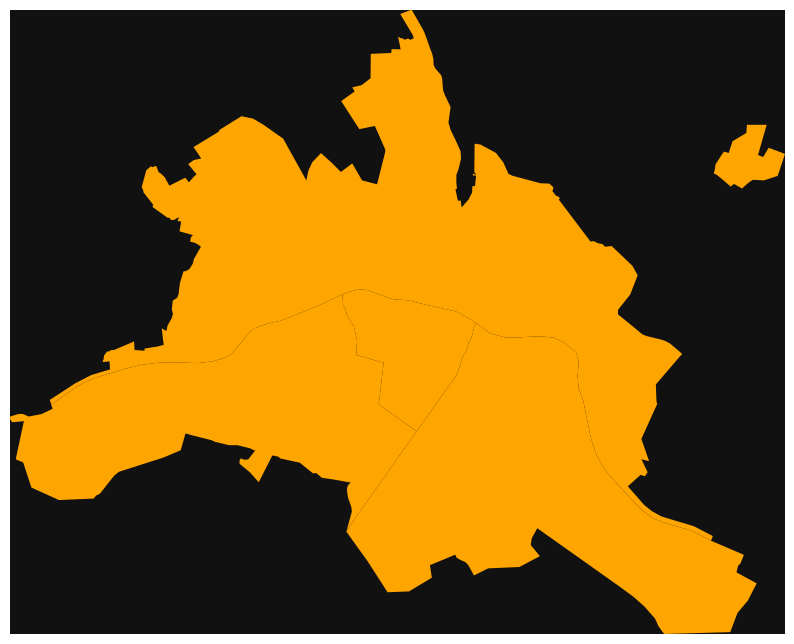

Tver, Tver Oblast, Central Federal District, Russia


In [33]:
tags_city = {'admin_level': ['9']}
try:#Ищем округа, через зону заданную bbox, потому что иногда OpenStreetMap ищет не там где надо
    gdf_city_region = ox.features_from_bbox(gdf_city["bbox_north"][0],gdf_city["bbox_south"][0],gdf_city["bbox_east"][0],gdf_city["bbox_west"][0], tags_city)
except:
    gdf_city_region = ox.features_from_bbox(gdf_city["bbox_north"][0],gdf_city["bbox_south"][0],gdf_city["bbox_east"][0],gdf_city["bbox_west"][0], {"place":["city","town"]})

        

fig, ax = ox.plot_footprints(gdf_city_region, figsize=(10, 10))
index_city_region = gdf_city_region.index
print(gdf_city["display_name"][0])

Разюиваем на зоны(регионы) 

In [34]:
areas=[]
for i in index_city_region:
    if i[0] == "relation":
        gdf_area = ox.geocode_to_gdf("R"+str(i[1]), by_osmid=True)
        areas.append(gdf_area)

Функция определения расстояния между объектами, если расстояние <100 запоминаем объект

In [22]:
def find_violations(gdf_bad,gdf_educational):
    violations=[]
    gdf_bad = ox.project_gdf(gdf_bad, to_crs =3857)
    gdf_educational = ox.project_gdf(gdf_educational, to_crs =3857)
    for index, p in gdf_educational.iterrows():
        distance=p["geometry"].distance(gdf_bad["geometry"])
        index_distance = distance.index
        for idx,dist in enumerate(distance):
            if dist <= 100:
                violations.append({"name":p["name"],"street": p["addr:street"],"bad":get_name(index_distance[idx])})
    return violations    

Функция определения средней удаленности отрицательных точек в городе от парковв

In [23]:
def find_average_distance(gdf_bad,gdf_park):
    distance_array=[]
    gdf_bad = ox.project_gdf(gdf_bad, to_crs =3857)
    gdf_park = ox.project_gdf(gdf_park, to_crs =3857)
    for p in gdf_park["geometry"]:
        distance=p.distance(gdf_bad["geometry"])
        index_distance = distance.index
        min=10000000
        for idx,dist in enumerate(distance):#ищю ближайшую точку до парка
            if min>dist:
                min=dist
        distance_array.append([index_distance[idx],min])# запоминаю только ближайщую точнку
    average_distance=0
    count=0
    for p in distance_array:# вычисляю среднее растояние в регионе
        count+=1
        average_distance+=p[1]  
    return average_distance/count  

Функция вычисления растояния до ближайшей остановки

In [24]:
def find_transport_distance(gdf_transport,gdf_park):
    distance_array=[]
    gdf_transport = ox.project_gdf(gdf_transport, to_crs =3857)
    gdf_park = ox.project_gdf(gdf_park, to_crs =3857)
    for index,p in gdf_park.iterrows():
        distance=p["geometry"].distance(gdf_transport["geometry"])
        index_distance = distance.index
        min=10000000
        for idx,dist in enumerate(distance):
            if min>dist:
                min=dist
        if min>200:
            distance_array.append({"name":p["name"],"street": p["addr:street"]})
    return distance_array           

Получить название объекта по его osmid

In [25]:
def get_name(name):
    gdf_area_local = ox.geocode_to_gdf(name[0][0]+str(name[1]), by_osmid=True)
    return gdf_area_local["display_name"][0]

Создаем зависимости, которые позволят, подгружать необходимые объекты для анализа

In [26]:
tags_good = {
    'amenity': "marketplace",
    "building": "riding_hall",
    "highway":"cycleway",
    "leisure":["swimming_pool","stadium","fitness_centre","sports_hall","sports_centre","pitch","park","playground","picnic_table",
               "nature_reserve","track","fitness_centre","fitness_station","stadium","outdoor_seating","golf_course","garden","common",
               "sports_hall","dog_park","resort","horse_riding","fishing","water_park","beach_resort","miniature_golf","ice_rink",
               "bird_hide","swimming_area","bandstand","schoolyard","disc_golf_course","hackerspace","summer_camp","indoor_play","trampoline_park",
               "bathing_place","wildlife_hide","barefoot","paddling_pool","village_swing","sunbathing","foot_bath","soccer_golf","wellness"],
    "shop":["greengrocer","agrarian","farm"]}
tags_bad = {
        'amenity': ["bar", "fast_food", "biergarten", "pub"],
        "shop": ["cigarettes", "e-cigarette", "vape", "vape_shop", "tobacco", "wine","brewing_supplies",
                 "beverages", "alcohol", "beer", "beverages", "pizza", "fast_food","kiosk","convenience"],
        "cuisine": ["pizza", "burger", "shawarma"]}
tags_park = {"leisure":["park","wildlife_hide","dog_park"]}
tags_cigarettes = {"shop":["cigarettes","e-cigarette","vape","vape_shop","tobacco","kiosk","convenience"]}
tags_alcohol = {'amenity': ["bar","biergarten","pub"], "shop":["wine","beverages","alcohol","beer","brewing_supplies","kiosk","convenience"]}
tags_educational = {'amenity': ["school","kindergarten","university","college","music_school","language_school","dancing_school","trade_school"]}
tags_transport = {'highway': "bus_stop", "public_transport": ["platform", "stop_position"]}

In [28]:
result=dict();
rating_city=0
average_distance_city=0
positive_city=0
for area in areas:# перебираем районы
    # Получаем объекты
    gdf_good = ox.features_from_polygon(area["geometry"][0], tags_good)
    gdf_park = ox.features_from_polygon(area["geometry"][0], tags_park)
    gdf_cigarettes = ox.features_from_polygon(area["geometry"][0], tags_cigarettes)
    gdf_alcohol = ox.features_from_polygon(area["geometry"][0], tags_alcohol)
    gdf_bad = ox.features_from_polygon(area["geometry"][0], tags_bad)
    gdf_educational = ox.features_from_polygon(area["geometry"][0], tags_educational)
    gdf_transport = ox.features_from_polygon(area["geometry"][0], tags_transport)
    
    # Вычисление необходимых данных
    violations=find_violations(gdf_bad,gdf_educational.copy(deep=True))
    average_distance_region=find_average_distance(gdf_bad,gdf_park)
    average_distance_city+=average_distance_region
    distance_transport_region=find_transport_distance(gdf_transport, gdf_educational.copy(deep=True))

    # Формирование данных, для передачи на фронт
    result[area["display_name"][0]]=dict();
    result[area["display_name"][0]]["good"]=len(gdf_good)
    result[area["display_name"][0]]["park"]=len(gdf_park)
    result[area["display_name"][0]]["cigarettes"]=len(gdf_cigarettes)
    result[area["display_name"][0]]["alcohol"]=len(gdf_alcohol)
    result[area["display_name"][0]]["educational"]=len(gdf_educational)
    result[area["display_name"][0]]["bad"]=len(gdf_bad)
    result[area["display_name"][0]]["positive"]=len(gdf_good)*0.5-len(gdf_bad)
    result[area["display_name"][0]]["violations"]={"len":len(violations),"data":violations}
    
    # Список образовательных организаций без доступа к остановке, отключил чтобы не засорять консоль
    #result[area["display_name"][0]]["transport"]={"len":len(distance_transport_region),"data":distance_transport_region}

    # poligin района тут скрыт чтобы не засорять консоль
    #result[area["display_name"][0]]["geometry"]=geopandas.GeoSeries(area["geometry"][0]).to_json()
    result[area["display_name"][0]]["average_distance"]=average_distance_region
    result[area["display_name"][0]]["rating"]=0
    if result[area["display_name"][0]]["positive"]>0:
        positive_city+=1
        result[area["display_name"][0]]["rating"]+=60
    else:
        positive_city-=1
    if result[area["display_name"][0]]["violations"]["len"]==0:
        result[area["display_name"][0]]["rating"]+=40  
# Собираем данные по городу
average_distance_city=average_distance_city/len(areas)
if average_distance_city>200:
    rating_city+=30
if positive_city>0:
    rating_city+=70
for area in areas:
    result[area["display_name"][0]]["city"]=dict()
    result[area["display_name"][0]]["city"]["rating"]=rating_city
    result[area["display_name"][0]]["city"]["average_distance"]=average_distance_city
    result[area["display_name"][0]]["city"]["positive"]=positive_city
display(result)    

{'Зареченский территориальный округ, городской округ Тула, Tula Oblast, Central Federal District, Russia': {'good': 141,
  'park': 8,
  'cigarettes': 64,
  'alcohol': 70,
  'educational': 45,
  'bad': 85,
  'positive': -14.5,
  'violations': {'len': 2,
   'data': [{'name': 'Хрущёвская средняя общеобразовательная школа им. А.И. Миронова',
     'street': 'Центральная улица',
     'bad': '140, Центральная улица, Хрущёво, Зареченский территориальный округ, городской округ Тула, Tula Oblast, Central Federal District, 301115, Russia'},
    {'name': 'Школа-сад №1',
     'street': nan,
     'bad': 'Ствольная улица, Малые Гончары, Зареченский территориальный округ, Tula, городской округ Тула, Tula Oblast, Central Federal District, 300044, Russia'}]},
  'average_distance': 1319.6534660709337,
  'rating': 0,
  'city': {'rating': 30,
   'average_distance': 1043.213767586743,
   'positive': -3}},
 'Привокзальный территориальный округ, городской округ Тула, Tula Oblast, Central Federal District, Rus